In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb(pretty=True)

In [2]:
import time
import jax
import os
import re
import pickle
import numpy as np
import jax.numpy as jnp
import scipy.spatial
import matplotlib.pyplot as plt
from confirm.mini_imprint import grid
from confirm.lewislib import grid as lewgrid
from confirm.lewislib import lewis, batch
from confirm.mini_imprint import binomial

import lewis_tune_sim as lts

from rich import print as rprint

In [3]:
# Configuration used during simulation
name = "4d"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}


In [4]:
# Configuration used during simulation
name = "3d"
params = {
    "n_arms": 3,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

In [5]:
lei_obj = lewis.Lewis45(**params)
n_arm_samples = int(lei_obj.unifs_shape()[0])

In [6]:
n_arms = params["n_arms"]
ns = np.concatenate(
    [np.ones(n_arms - 1)[:, None], -np.eye(n_arms - 1)],
    axis=-1,
)
null_hypos = [grid.HyperPlane(n, 0) for n in ns]
symmetry = []
for i in range(n_arms - 2):
    n = np.zeros(n_arms)
    n[i + 1] = 1
    n[i + 2] = -1
    symmetry.append(grid.HyperPlane(n, 0))

theta_min = -2.0
theta_max = 2.0
init_grid_size = 8
theta, radii = grid.cartesian_gridpts(
    np.full(n_arms, theta_min),
    np.full(n_arms, theta_max),
    np.full(n_arms, init_grid_size),
)
g_raw = grid.build_grid(theta, radii)

In [7]:
target_grid_cost = 0.002
target_sim_cost = 0.002
target_alpha = 0.025
holderq = 6

grid_batch_size = 2**6 if jax.devices()[0].device_kind == "cpu" else 2**10
max_sim_size = 2**17
init_nsims = 2000
seed = 0
key = jax.random.PRNGKey(seed)

unifs = jax.random.uniform(key=key, shape=(max_sim_size,) + lei_obj.unifs_shape())
unifs_order = np.arange(0, unifs.shape[1])
n_bootstrap = 30
bootstrap_idxs = {
    K: jnp.concatenate((
        jnp.arange(K)[None, :],
        jax.random.choice(key, np.arange(K), shape=(n_bootstrap, K), replace=True)
    ))
    for K in [1000]
}

batched_tune = lts.grouped_by_sim_size(lei_obj, lts.tunev, grid_batch_size)
batched_rej = lts.grouped_by_sim_size(lei_obj, lts.rejv, grid_batch_size)
batched_invert_bound = batch.batch_all_concat(
    lambda *args: (binomial.invert_bound(*args),),
    grid_batch_size,
    in_axes=(None, 0, 0, None, None),
)
batched_many_rej = lts.grouped_by_sim_size(lei_obj, lts.rejvv, grid_batch_size)

In [164]:
(1000 * 2 ** np.arange(1, 6))

array([ 2000,  4000,  8000, 16000, 32000])

In [165]:
max_sim_size

131072

In [8]:
load_iter = 'latest'
if load_iter == 'latest':
    # find the file with the largest checkpoint index: name/###.pkl 
    available_iters = [int(fn[:-4]) for fn in os.listdir(name) if re.match(r'[0-9]+.pkl', fn)]
    load_iter = 0 if len(available_iters) == 0 else max(available_iters)

if load_iter == 0:
    g = grid.build_grid(
        theta, radii, null_hypos=null_hypos, symmetry_planes=symmetry, should_prune=True
    )
    sim_sizes = np.full(g.n_tiles, init_nsims)
    sim_cvs = np.empty(g.n_tiles, dtype=float)
    pointwise_target_alpha = np.empty(g.n_tiles, dtype=float)
    todo = np.ones(g.n_tiles, dtype=bool)
    # TODO: remove
    typeI_sum = None
    hob_upper = None
else:
    fn = f"{name}/{load_iter}.pkl"
    print(f'loading checkpoint {fn}')
    with open(fn, "rb") as f:
        (
            g,
            sim_sizes,
            sim_cvs,
            typeI_sum,
            hob_upper,
            pointwise_target_alpha,
        ) = pickle.load(f)
    todo = np.zeros(g.n_tiles, dtype=bool)
    todo[-1] = True

loading checkpoint 3d/107.pkl


## Goofing around

In [9]:
batched_sim = lts.grouped_by_sim_size(lei_obj, lts.simv, grid_batch_size)

K = 1000

widx = np.argmin(sim_cvs)
idxs = np.arange(widx, widx + 1)
idxs = np.argsort(sim_cvs)[:10*grid_batch_size]
test_stats, best_arms = batched_sim(sim_sizes[idxs], (g.theta_tiles[idxs],), (unifs,), unifs_order)
false_test_stats = jnp.where(g.null_truth[np.arange(idxs.shape[0])[:, None], best_arms - 1], test_stats, 3.0)
_tunev = jax.vmap(lts._tune, in_axes=(0, None, None))
sim_cv = _tunev(false_test_stats, K, pointwise_target_alpha[idxs])

In [156]:
idxs = np.argsort(sim_cvs)[:grid_batch_size]


In [157]:
bootstrap_sim_cvs = bootstrap_tune_runner(
    sim_sizes[idxs],
    pointwise_target_alpha[idxs],
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    bootstrap_idxs,
    unifs_order,
)
bootstrap_cvs = bootstrap_sim_cvs.min(axis=0)
overall_cv = bootstrap_cvs[0]
overall_cv, bootstrap_cvs

(0.08046881982747489,
 array([0.08046882, 0.07638   , 0.1225537 , 0.05385244, 0.08091444, 0.08046882, 0.16798557,
        0.07506383, 0.1225537 , 0.16798557, 0.21216218, 0.03741701, 0.05385244, 0.16798557,
        0.03741701, 0.1225537 , 0.07506383, 0.06428037, 0.06428037, 0.15949816, 0.07506383,
        0.11191954, 0.05962014, 0.07506383, 0.08346577, 0.04775709, 0.06428037, 0.07638   ,
        0.07571061, 0.06428037, 0.07571061]))

In [158]:

bootstrap_cv_rej = batched_many_rej(
    sim_sizes[idxs],
    (np.tile(bootstrap_cvs[None, :], (idxs.shape[0], 1)),
    g.theta_tiles[idxs],
    g.null_truth[idxs],),
    (unifs[:K],),
    unifs_order
)

running for size 1000 with 1024 tiles took 9.497791290283203


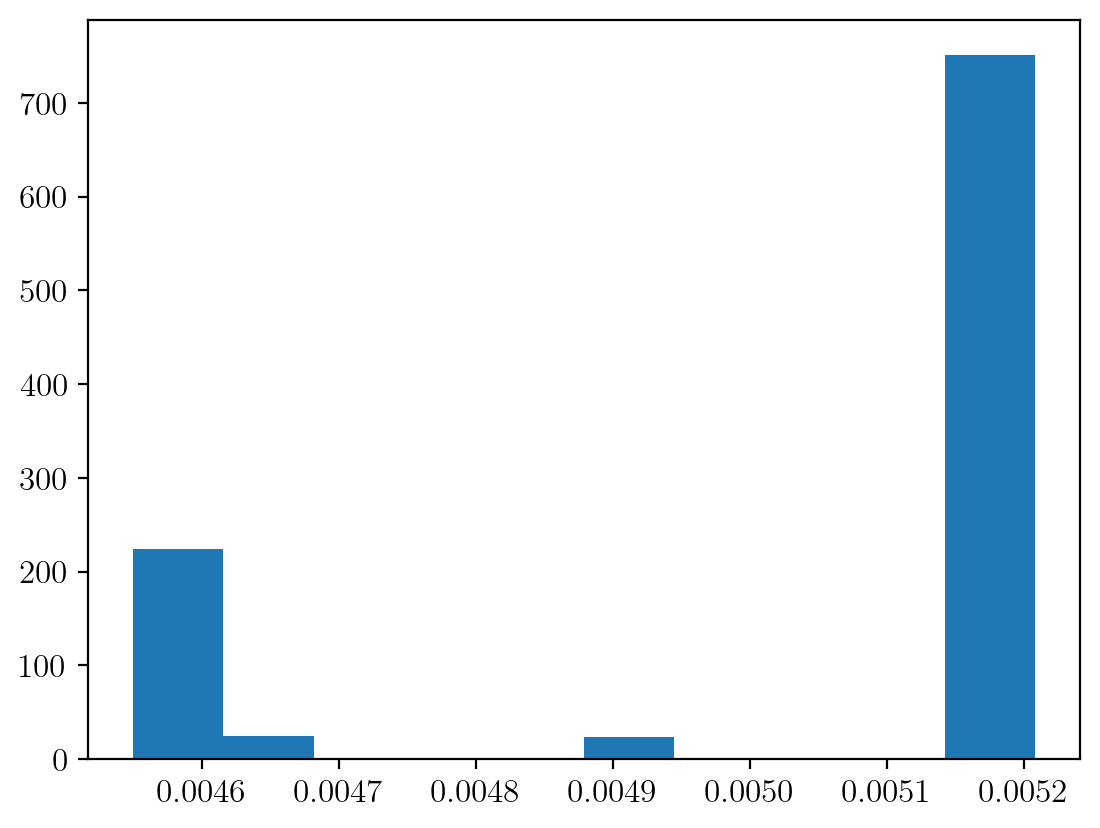

In [159]:
plt.hist(np.sqrt(bootstrap_cv_rej.var(axis=1)) / K)
plt.show()

In [107]:
n_bootstrap = 30
bootstrap_idxs = jax.random.choice(key, np.arange(K), shape=(n_bootstrap, K), replace=True)
bootstrap_sim_cv = np.array([_tunev(false_test_stats[:, bootstrap_idxs[i]], K, target_alpha) for i in range(n_bootstrap)])
bootstrap_cv = bootstrap_sim_cv.min(axis=1)

check_idxs = np.arange(widx, widx + 1)
check_idxs = idxs#[grid_batch_size]
# bootstrap_cv_rej = rejvv(
#     lei_obj,
#     np.tile(bootstrap_cv[None, :], (check_idxs.shape[0], 1)),
#     g.theta_tiles[check_idxs],
#     g.null_truth[check_idxs],
#     unifs[:K],
#     unifs_order
# )[0]
bootstrap_cv_rej = batched_many_rej(
    sim_sizes[check_idxs],
    (np.tile(bootstrap_cv[None, :], (check_idxs.shape[0], 1)),
    g.theta_tiles[check_idxs],
    g.null_truth[check_idxs],),
    (unifs[:K],),
    unifs_order
)

running for size 1000 with 10240 tiles took 3.2488536834716797


In [108]:
bootstrap_cv_rej.shape

(10240, 30)

(array([ 632., 1838.,  142.,    0.,    0.,    8.,   72.,  653.,   87., 6808.]),
 array([0.00499121, 0.00505345, 0.00511569, 0.00517792, 0.00524016, 0.00530239, 0.00536463,
        0.00542687, 0.0054891 , 0.00555134, 0.00561357]),
 <BarContainer object of 10 artists>)

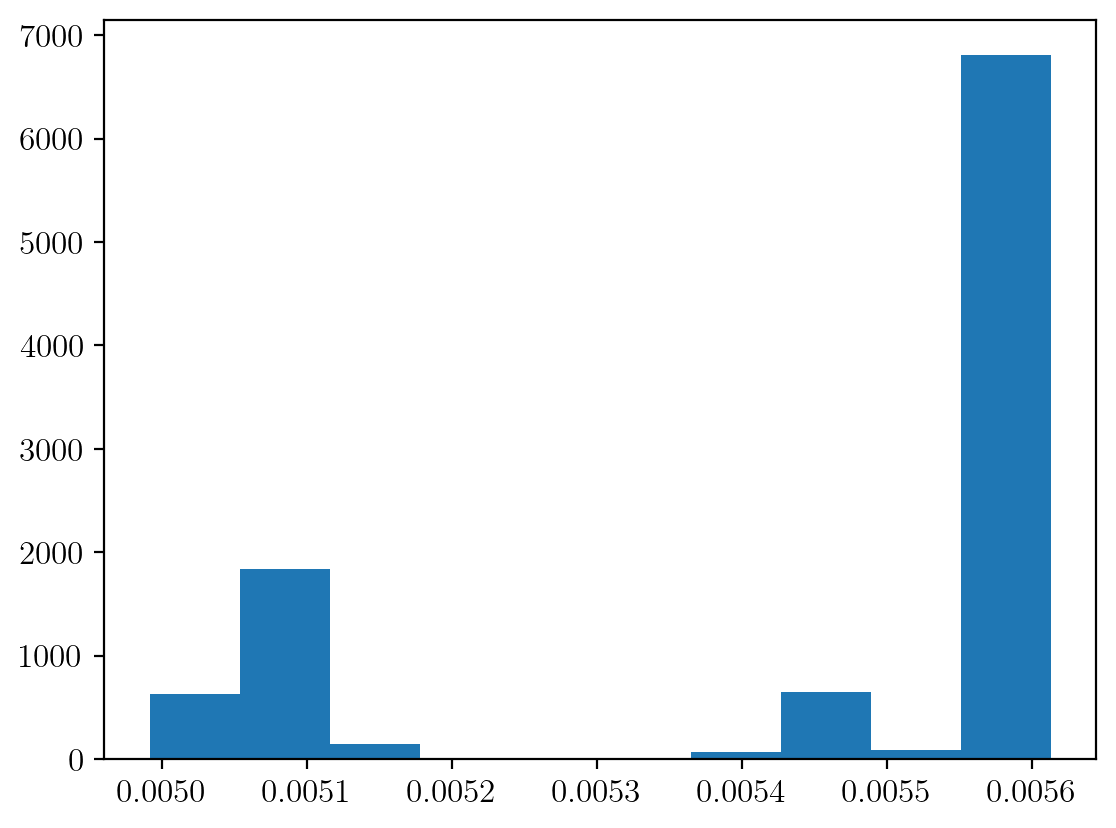

In [110]:
plt.hist(np.sqrt(bootstrap_cv_rej.var(axis=1)) / K)

In [52]:
bootstrap_cv_rej[0]

(30, 1)

(array([2., 1., 2., 6., 7., 3., 4., 1., 2., 2.]),
 array([13. , 15.1, 17.2, 19.3, 21.4, 23.5, 25.6, 27.7, 29.8, 31.9, 34. ]),
 <BarContainer object of 10 artists>)

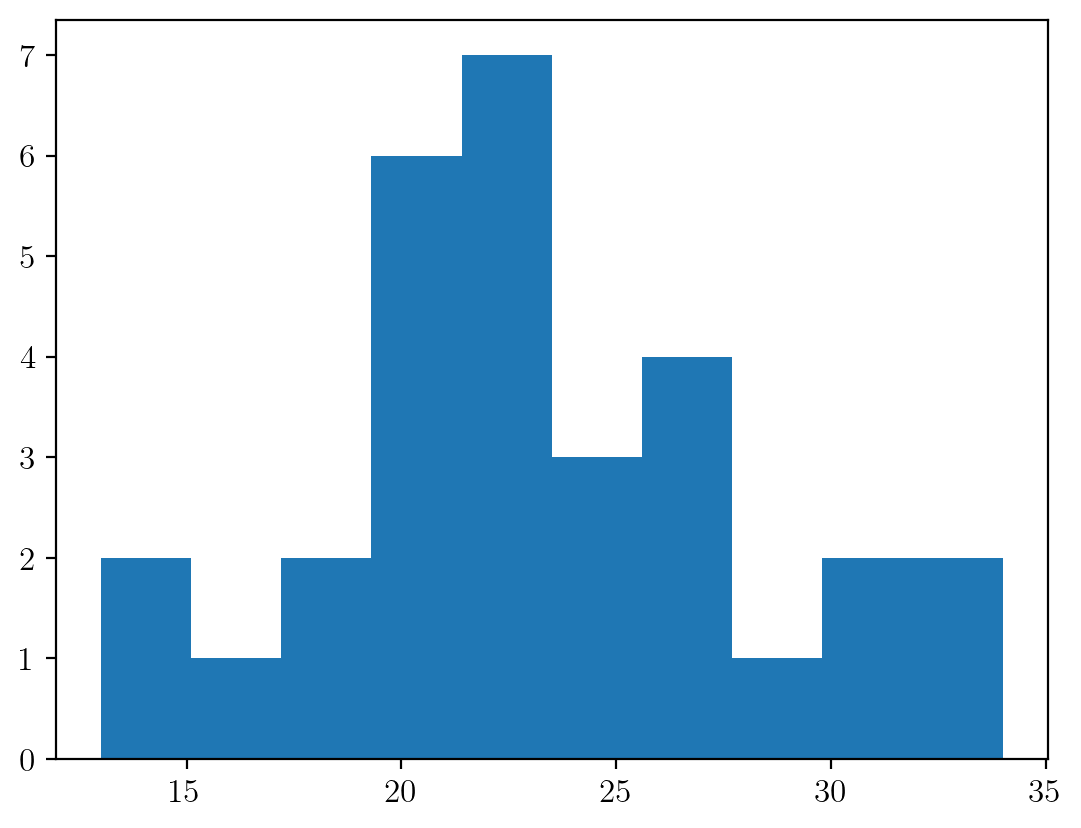

In [15]:
plt.hist(bootstrap_cv_rej)

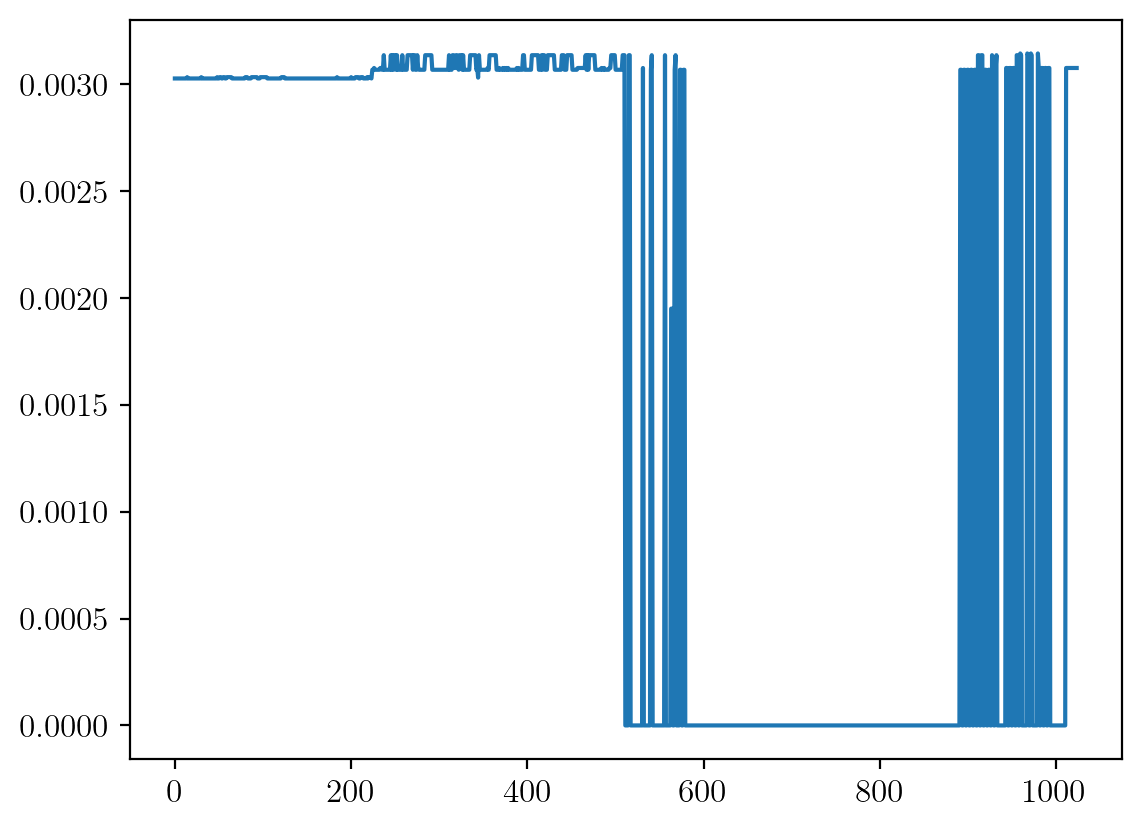

In [74]:
plt.plot(np.var(bootstrap_cv, axis=1))

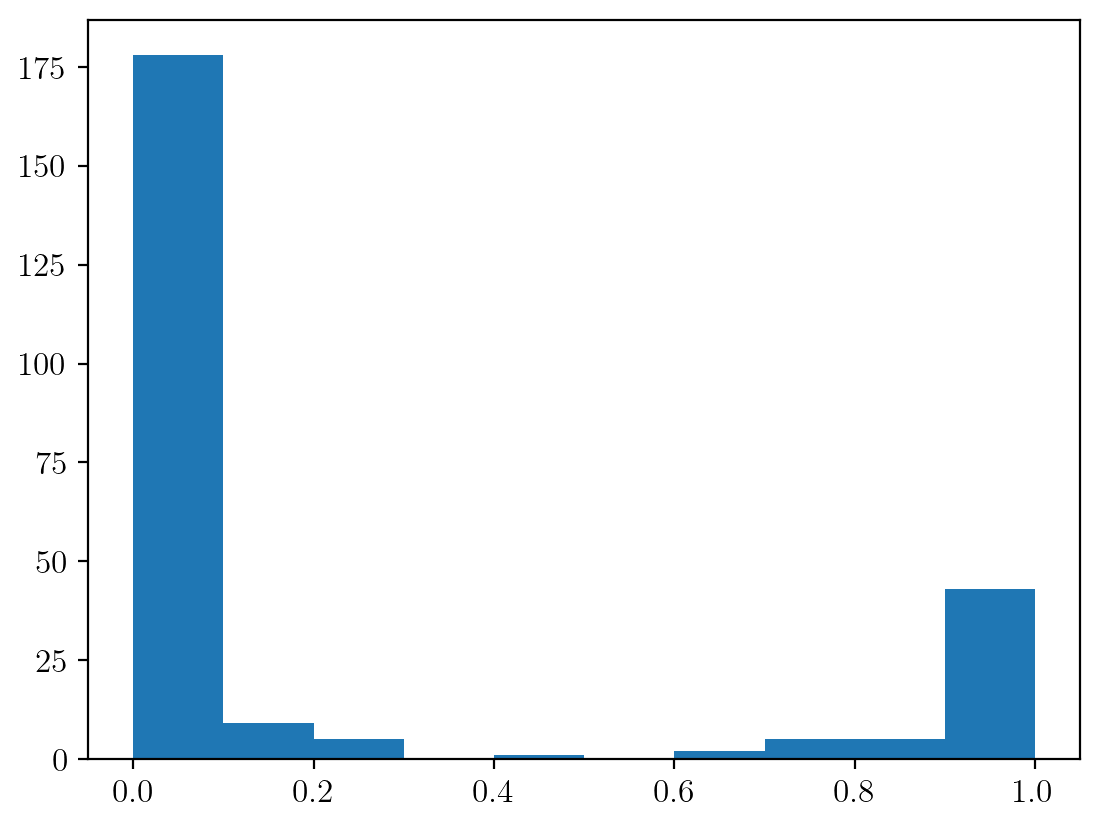

Bad pipe message: %s [b'&\xa1|\xc2\xd3Qd\x16a\x03\xad\xa9\x16\x12T?l\xeb\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0']
Bad pipe message: %s [b"R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t1"]
Bad pipe message: %s [b'.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04', b'\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'', b'\x03\x03']
Bad pipe message: %s [b'\x1f']
Bad pipe message: %s [b'']
Bad pipe message: %s [b';\x8d\xc2\xb2\xbb\x1a

In [12]:
plt.hist(np.sum(test_stat <= 0, axis=-1) / sim_sizes[idxs])
plt.show()

In [30]:
overall_cv = np.min(sim_cvs)
rej1 = batched_rej(sim_sizes[idxs], (np.full(idxs.shape[0], overall_cv), g.theta_tiles[idxs], g.null_truth[idxs]), unifs, unifs_order)

running for size 1000 with 10240 tiles took 3.391737222671509


In [31]:
key2 = jax.random.PRNGKey(seed+1)
unifs2 = jax.random.uniform(key=key2, shape=(max_sim_size,) + lei_obj.unifs_shape())
rej2 = batched_rej(sim_sizes[idxs], (np.full(idxs.shape[0], overall_cv), g.theta_tiles[idxs], g.null_truth[idxs]), unifs2, unifs_order)

running for size 1000 with 10240 tiles took 3.389974594116211


In [32]:
rej1, rej2

(array([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, ..., 22, 22, 23, 23, 23, 23, 23, 23, 23, 23]),
 array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8, ...,  8,  8, 10,  9,  9,  9,  9, 10, 10, 10]))

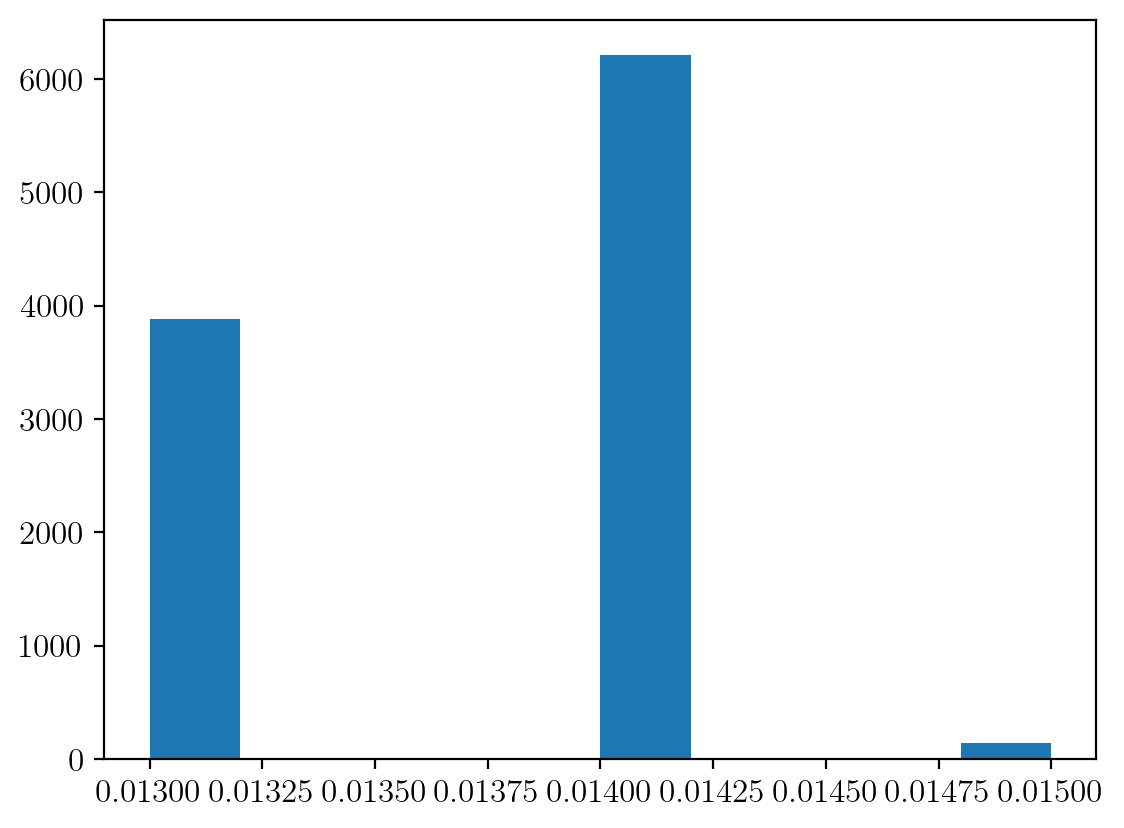

In [33]:
plt.hist((rej1 - rej2) / (sim_sizes[idxs]))
plt.show()

In [63]:
checksims = np.where(sim_cvs <= adafrac * overall_cv)[0][:(10*grid_batch_size)]
typeI_sum_check = batched_rej(
    sim_sizes[checksims],
    (np.full(checksims.shape[0], overall_cv),
    g.theta_tiles[checksims],
    g.null_truth[checksims],),
    unifs,
    unifs_order,
)

running for size 1000 with 10240 tiles took 3.410212516784668


In [66]:
np.min(typeI_sum_check / sim_sizes[checksims])

0.021

In [116]:
sim_sizes[checksims] = 128000
est, ci = binomial.zero_order_bound(pointwise_target_alpha[checksims] * sim_sizes[checksims], sim_sizes[checksims], 0.05, 1.0)

In [117]:
np.argmax(est + ci)

DeviceArray(7935, dtype=int64)

In [118]:
np.max(ci)

DeviceArray(0.00072802, dtype=float64)

## The big run

In [44]:
adafrac = 1.10
iter_max = 1000
cost_per_sim = 500e-9
for II in range(load_iter + 1, iter_max):
    if np.sum(todo) == 0:
        break

    print(f"starting iteration {II} with {np.sum(todo)} tiles to process")
    if cost_per_sim is not None:
        predicted_time = np.sum(sim_sizes[todo] * cost_per_sim)
        print(f'runtime prediction: {predicted_time:.2f} seconds')

    start = time.time()
    pointwise_target_alpha[todo] = batched_invert_bound(
        target_alpha, g.theta_tiles[todo], g.vertices[todo], n_arm_samples, holderq
    )[0]
    print("inverting the bound took", time.time() - start)
    start = time.time()

    sim_cvs[todo] = batched_tune(
        sim_sizes[todo],
        (pointwise_target_alpha[todo],
        g.theta_tiles[todo],
        g.null_truth[todo],),
        unifs,
        unifs_order,
    )
    worst_tile = np.argmin(sim_cvs)
    overall_cv = np.min(sim_cvs)
    cost_per_sim = min((time.time() - start) / np.sum(sim_sizes[todo]), 500e-9)
    todo[:] = False
    print("tuning took", time.time() - start)

    savedata = [g, sim_sizes, sim_cvs, None, None, pointwise_target_alpha]
    with open(f"{name}/{II}.pkl", "wb") as f:
        pickle.dump(savedata, f)


    hob_theory_cost = target_alpha - pointwise_target_alpha
    which_refine = (sim_cvs <= adafrac * overall_cv) & (
        hob_theory_cost > target_grid_cost
    )
    impossible_alpha = np.floor(pointwise_target_alpha * (sim_sizes + 1)) - 1 <= 0
    which_refine |= impossible_alpha
    
    which_addsims = np.zeros_like(which_refine)
    if np.all(~which_refine):
        which_addsims = np.argsort(sim_cvs)[:(5*grid_batch_size)]
        # checksims = np.argsort(sim_cvs)[:(5*grid_batch_size)]
        # print(checksims.shape)
        # typeI_sum_check = batched_rej(
        #     sim_sizes[checksims],
        #     (np.full(checksims.shape[0], overall_cv),
        #     g.theta_tiles[checksims],
        #     g.null_truth[checksims],),
        #     unifs,
        #     unifs_order,
        # )
        # typeI_est_check = typeI_sum_check / sim_sizes[checksims]
        # typeI_est_check > pointwise_target_alpha[checksims] - 

    report = dict(
        II=II,
        overall_cv=overall_cv,
        n_tiles=g.n_tiles,
        n_refine=np.sum(which_refine),
        n_refine_impossible=np.sum(impossible_alpha),
        grid_cost=f"{hob_theory_cost[worst_tile]:.4f}",
    )
    rprint(report)

    if (np.sum(which_refine) > 0) and II != iter_max - 1:

        refine_tile_idxs = np.where(which_refine)[0]
        refine_gridpt_idxs = g.grid_pt_idx[refine_tile_idxs]
        new_thetas, new_radii, unrefined_grid, keep_tile_idxs = grid.refine_grid(
            g, refine_gridpt_idxs
        )
        new_grid = grid.build_grid(
            new_thetas,
            new_radii,
            null_hypos=g.null_hypos,
            symmetry_planes=symmetry,
            should_prune=True,
        )
        nearest_parent_tiles = scipy.spatial.KDTree(g.theta_tiles).query(
            new_grid.theta_tiles, k=2
        )
        new_sim_sizes = np.max(sim_sizes[nearest_parent_tiles[1]], axis=1).astype(int)

        old_g = g
        g = grid.concat_grids(unrefined_grid, new_grid)

        sim_sizes = np.concatenate([sim_sizes[keep_tile_idxs], new_sim_sizes])
        todo = np.concatenate(
            [todo[keep_tile_idxs], np.ones(new_grid.n_tiles, dtype=bool)]
        )
        sim_cvs = np.concatenate(
            [sim_cvs[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        )
        pointwise_target_alpha = np.concatenate(
            [
                pointwise_target_alpha[keep_tile_idxs],
                np.empty(new_grid.n_tiles, dtype=float),
            ]
        )
        continue
    else:
        sim_sizes[which_addsims] *= 2
        todo[which_addsims] = True
        continue
    print("done!")
    break

starting iteration 107 with 1 tiles to process
runtime prediction: 0.00 seconds
inverting the bound took 0.1179506778717041
running for size 1000 with 1 tiles took 0.3466198444366455
tuning took 0.4805455207824707
(1024,)
running for size 1000 with 1024 tiles took 0.3422732353210449
running for size 10000 with 1024 tiles took 12.985175132751465
running for size 2000 with 1024 tiles took 9.495131969451904


{
    'II': 107,
    'overall_cv': 0.08046881982747489,
    'n_tiles': 4721515,
    'n_refine': 0,
    'n_refine_impossible': 0,
    'grid_cost': '0.0001'
}

done!


In [64]:

    # typeI_sum[todo] = batched_sim(
    #     sim_sizes[todo],
    #     np.full(todo.sum(), overall_cv),
    #     g.theta_tiles[todo],
    #     g.null_truth[todo],
    #     unifs,
    #     unifs_order,
    # )
    # import pickle

    # typeI_est, typeI_CI = binomial.zero_order_bound(
    #     typeI_sum, sim_sizes, delta_validate, 1.0
    # )
    # typeI_bound = typeI_est + typeI_CI
    # hob_upper = binomial.holder_odi_bound(
    #     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
    # )
    # sim_cost = typeI_CI
    # hob_empirical_cost = hob_upper - typeI_bound
    # which_refine = (
    #     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
    # ) & (
    #     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
    # )
    # which_more_sims = (
    #     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
    # ) & (
    #     (typeI_bound > adafrac * hob_upper[worst_tile])
    #     | (sim_cvs == sim_cvs[worst_tile])
    # )
        #
        # n_more_sims=np.sum(which_more_sims),
        # sim_cost=f"{sim_cost[worst_tile]:.4f}",
        #
        # sim_sizes[which_more_sims] *= 2
        # todo[which_more_sims] = True
        # typeI_sum = np.concatenate(
        #     [typeI_sum[keep_tile_idxs], np.zeros(new_grid.n_tiles, dtype=float)]
        # )
        # hob_upper = np.concatenate(
        #     [hob_upper[keep_tile_idxs], np.empty(new_grid.n_tiles, dtype=float)]
        # )
typeI_sum = batched_rej(
    sim_sizes,
    (np.full(sim_sizes.shape[0], overall_cv),
    g.theta_tiles,
    g.null_truth,),
    unifs,
    unifs_order,
)


running for size 1000 with 4721515 tiles took 1573.7245726585388


In [18]:

typeI_est, typeI_CI = binomial.zero_order_bound(
    typeI_sum, sim_sizes, delta_validate, 1.0
)
typeI_bound = typeI_est + typeI_CI

hob_upper = binomial.holder_odi_bound(
    typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
)
sim_cost = typeI_CI
hob_empirical_cost = hob_upper - typeI_bound

In [69]:
savedata = [
    g,
    sim_sizes,
    sim_cvs,
    typeI_sum,
    hob_upper,
    pointwise_target_alpha
]
with open(f"{name}/final.pkl", "wb") as f:
    pickle.dump(savedata, f)

In [97]:
worst_idx = np.argmax(typeI_est)
worst_tile = g.theta_tiles[worst_idx]
typeI_est[worst_idx], worst_tile

(0.023, array([-0.11962891, -0.12060547, -0.98388672]))

In [21]:
worst_cv_idx = np.argmin(sim_cvs)
typeI_est[worst_cv_idx], sim_cvs[worst_cv_idx], g.theta_tiles[worst_cv_idx], pointwise_target_alpha[worst_cv_idx]

(0.023,
 0.08046881982747489,
 array([-0.14068604, -0.14117432, -0.99957275]),
 0.024880044489656025)

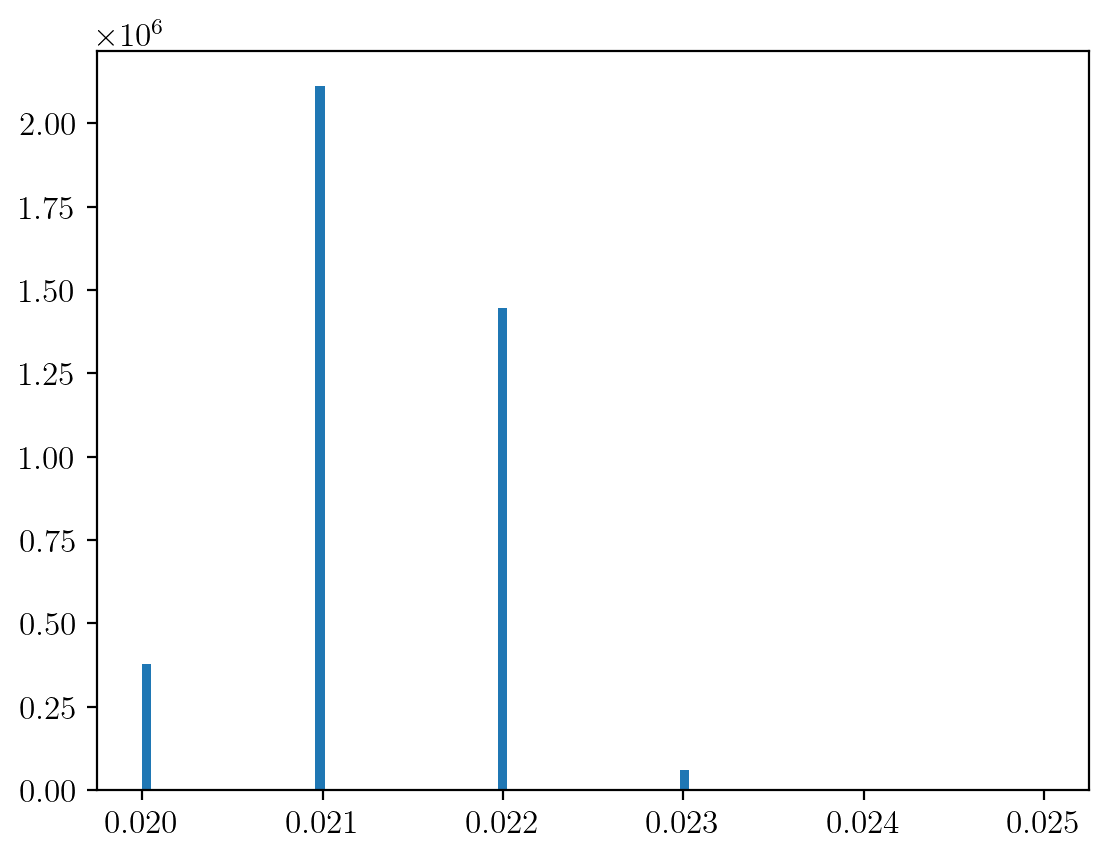

In [23]:
plt.hist(typeI_est, bins=np.linspace(0.02,0.025, 100))
plt.show()

In [72]:
np.sum((sim_cvs <= adafrac * overall_cv) & (hob_theory_cost > target_grid_cost))

0

In [38]:
hob_theory_cost[worst_cv_idx]

0.018794773783568718

In [36]:
1.1 * overall_cv

0.024925544805611037

In [17]:
pointwise_target_alpha[worst_idx]

0.02138854141734557

In [49]:
idxs = [worst_idx]
batched_sim(
    sim_sizes[idxs],
    np.full(1, sim_cvs[idxs]),
    g.theta_tiles[idxs],
    g.null_truth[idxs],
    unifs,
    unifs_order,
) / sim_sizes[idxs]

running for size 2000 with 1 tiles took 0.934185266494751


array([0.1145])

In [93]:
unplot

NameError: name 'unplot' is not defined

In [108]:
np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot])

array([[0.17626953],
       [0.17626953],
       [0.17626953],
       [0.17626953],
       [0.17626953],
       [0.17626953],
       [0.17626953],
       [0.17626953],
       [0.07373047],
       [0.07373047],
       ...,
       [0.02044678],
       [0.02044678],
       [0.02032471],
       [0.02032471],
       [0.02032471],
       [0.02032471],
       [0.02044678],
       [0.02044678],
       [0.02044678],
       [0.02044678]])

4536142


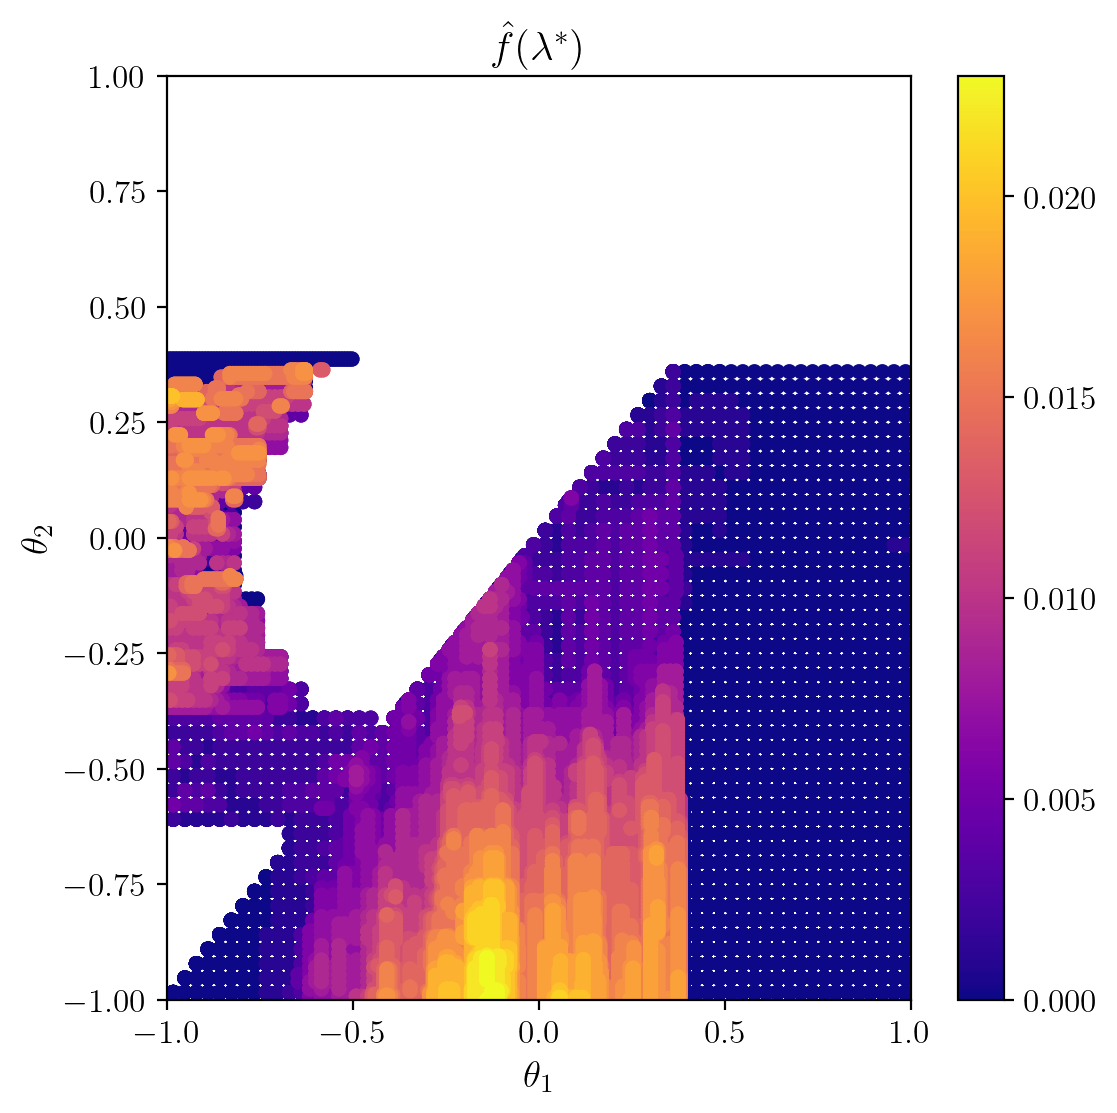

4552218


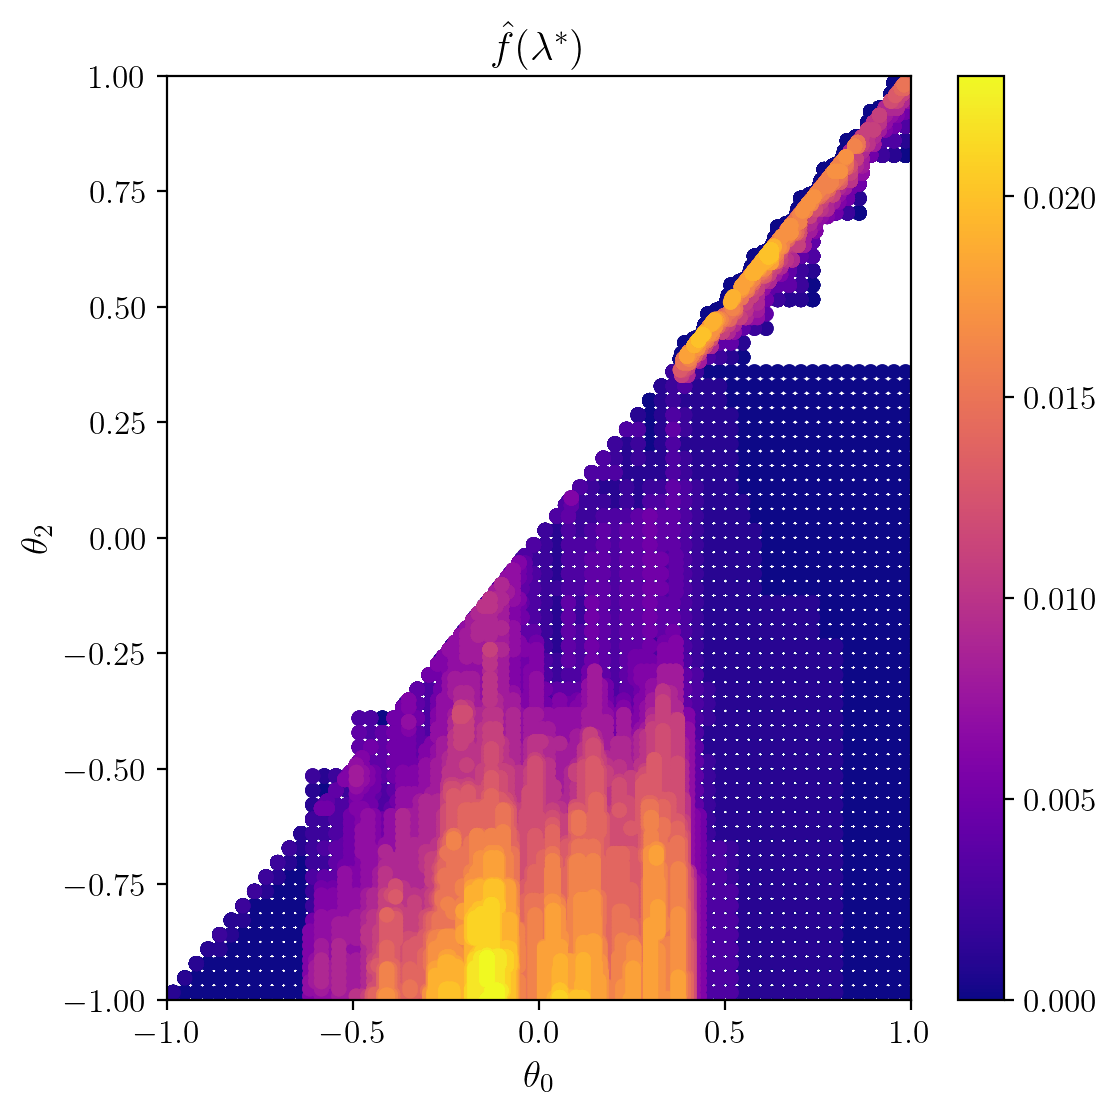

In [112]:
# def pandemonium(field):
field = typeI_est
# for unplot_set in [{0, 1}, {1, 2}]:
for unplot_set in [{0}, {1}]:
    plot = list(set(range(n_arms)) - unplot_set)
    unplot = list(unplot_set)
    select = np.where(np.all(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]) < 0.5, axis=-1))[
        0
    ]

    ordered_select = select[np.argsort(field[select])]
    print(ordered_select.shape[0])

    plt.figure(figsize=(6, 6))
    plt.title(r"$\hat{f}(\lambda^{*})$")
    plt.scatter(
        g.theta_tiles[ordered_select, plot[0]],
        g.theta_tiles[ordered_select, plot[1]],
        c=field[ordered_select],
        s=20,
    )
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.colorbar()
    plt.xlabel(f"$\\theta_{plot[0]}$")
    plt.ylabel(f"$\\theta_{plot[1]}$")
    plt.show()

295


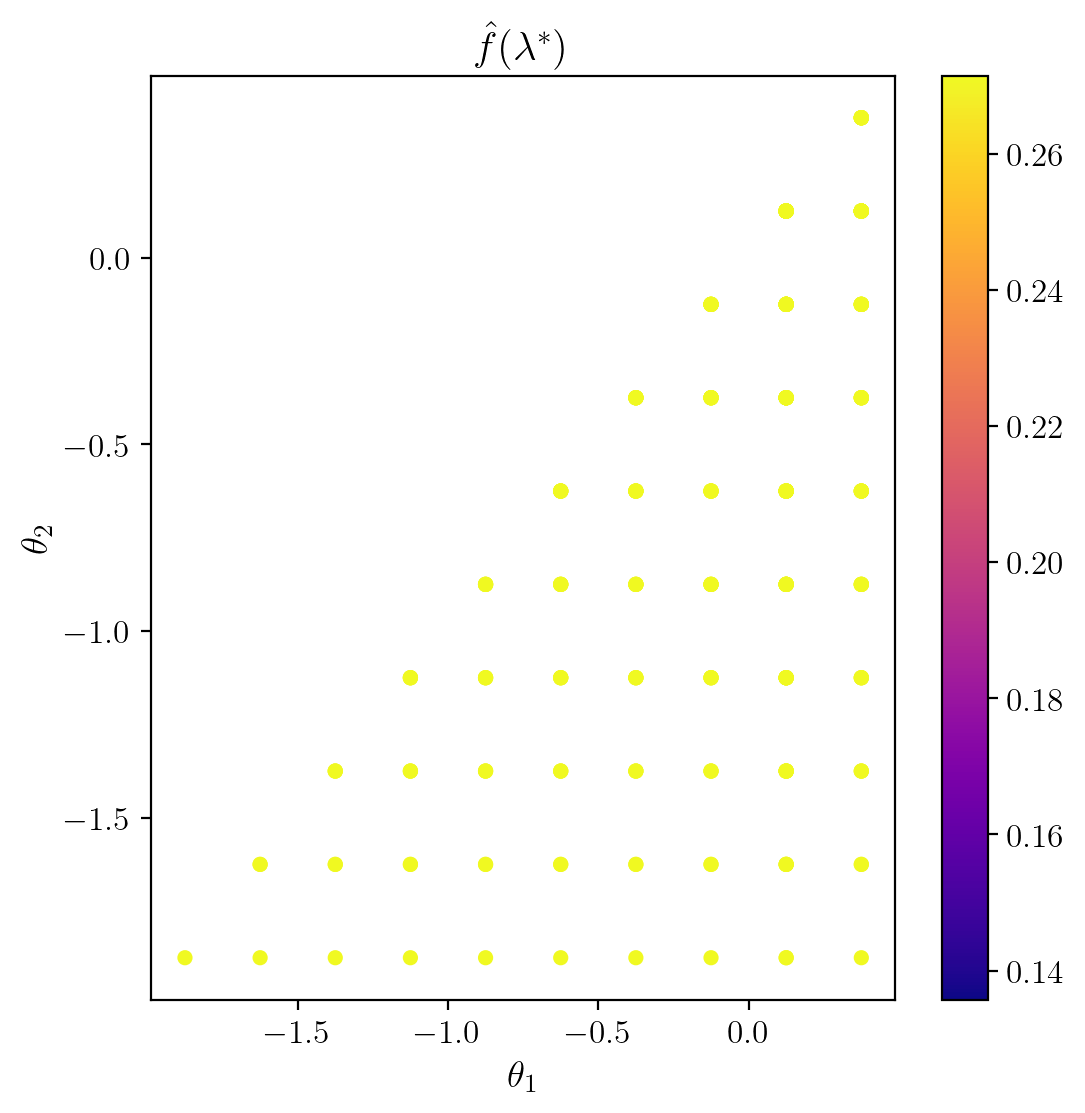

463


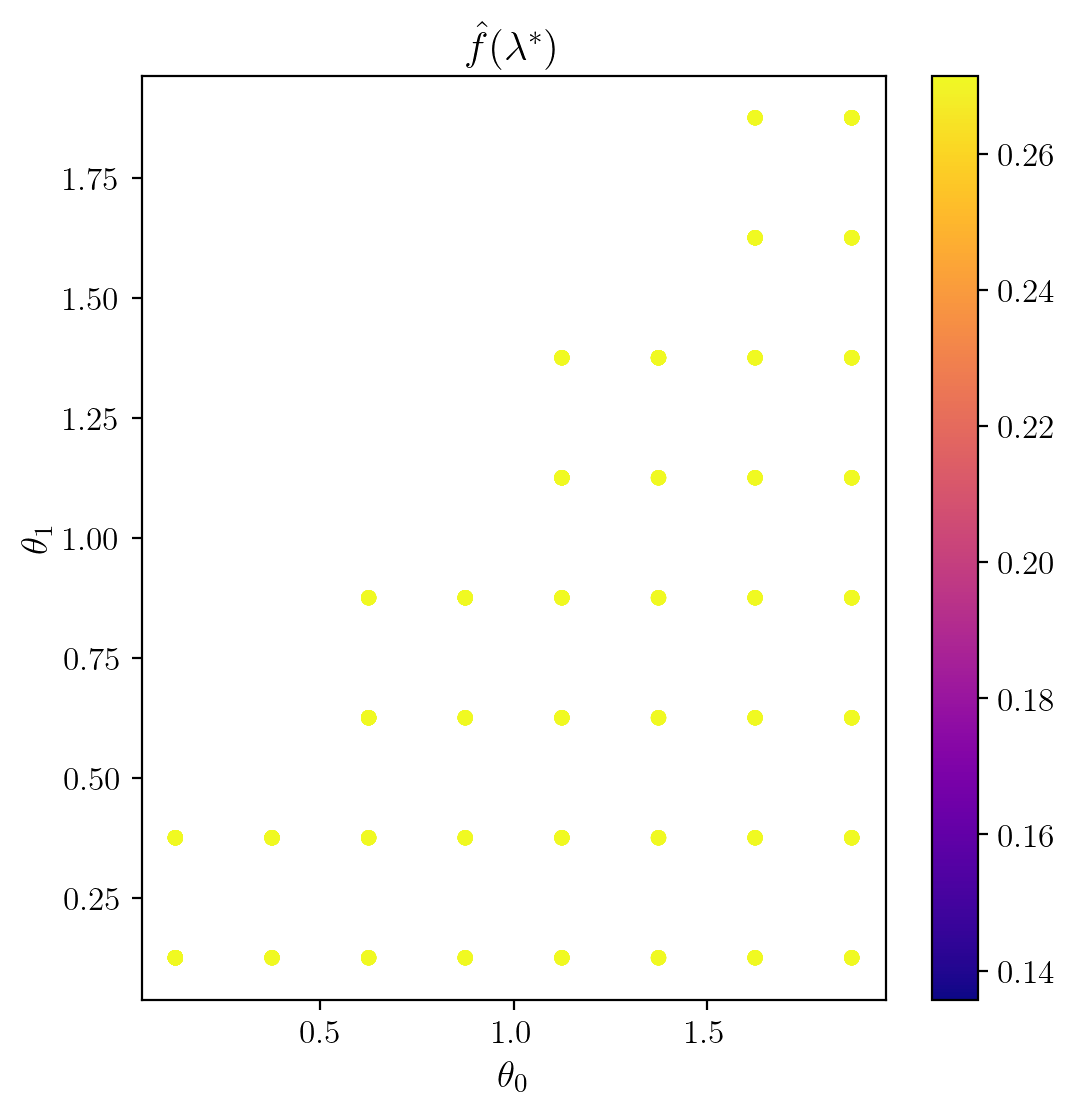

In [ ]:
for unplot in [0, 2]:
    plot = list({0, 1, 2} - {unplot})
    select = np.where(np.abs(g.theta_tiles[:, unplot] - worst_tile[unplot]) < 0.08)[0]

    ordered_select = select[np.argsort(sim_cvs[select])[::-1]]
    print(ordered_select.shape[0])

    plt.figure(figsize=(6, 6))
    plt.title(r"$\hat{f}(\lambda^{*})$")
    plt.scatter(
        g.theta_tiles[ordered_select, plot[0]],
        g.theta_tiles[ordered_select, plot[1]],
        c=sim_cvs[ordered_select],
        vmin=overall_cv,
        vmax=overall_cv * 2,
        s=20,
    )
    plt.colorbar()
    plt.xlabel(f"$\\theta_{plot[0]}$")
    plt.ylabel(f"$\\theta_{plot[1]}$")
    plt.show()

In [53]:
(2.0 / g.radii.min()) ** 3 / g.n_tiles

31442.172059354416

In [ ]:
# with open(f'checkpoint/6.pkl', 'rb') as f:
#     g, sim_sizes, sim_cvs, typeI_sum, hob_upper, pointwise_target_alpha = pickle.load(f)

# typeI_est, typeI_CI = binomial.zero_order_bound(
#     typeI_sum, sim_sizes, delta_validate, 1.0
# )
# typeI_bound = typeI_est + typeI_CI
# hob_upper = binomial.holder_odi_bound(
#     typeI_bound, g.theta_tiles, g.vertices, n_arm_samples, holderq
# )


# sim_cost = typeI_CI
# hob_theory_cost = target_alpha - pointwise_target_alpha
# hob_empirical_cost = hob_upper - typeI_bound

# worst_tile = np.argmin(sim_cvs)
# which_refine = (
#     hob_theory_cost > max(adafrac * hob_theory_cost[worst_tile], target_grid_cost)
# ) & (
#     (hob_upper > adafrac * hob_upper[worst_tile]) | (sim_cvs == sim_cvs[worst_tile])
# )
# which_more_sims = (
#     typeI_CI > max(adafrac * typeI_CI[worst_tile], target_sim_cost)
# ) & (
#     (typeI_bound > adafrac * hob_upper[worst_tile])
#     | (sim_cvs == sim_cvs[worst_tile])
# )

NameError: name 'adafrac' is not defined